In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

# Kendi paketimizden araçları çağıralım
from stats_for_mols.sampling import DataSplitter
from stats_for_mols.performance.metrics import MetricCalculator
from stats_for_mols.statistics import StatisticalValidator
from stats_for_mols.visualization.plots import plot_mcsim, plot_simultaneous_ci
from stats_for_mols.visualization.metrics_plot import MetricVisualizer
from stats_for_mols.visualization.diagnostics import plot_target_distribution

# Görsel stil
plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)

/nfs/home/myuecel3/stats_for_mols/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 1000 molekül, %10 aktiflik oranı (weights=[0.9, 0.1])
X, y = make_classification(
    n_samples=1000, 
    n_features=1024, 
    n_informative=50, 
    n_redundant=10, 
    weights=[0.9, 0.1], # %90 Negatif, %10 Pozitif (Imbalanced)
    flip_y=0.05,        # %5 gürültü (noise) ekle
    random_state=42
)

# DataFrame'e çevirelim
df = pd.DataFrame(X, columns=[f'fp_{i}' for i in range(1024)])
df['Activity'] = y # 0 veya 1
# Dummy SMILES (Scaffold split denemek isterseniz diye)
df['SMILES'] = ["C" * np.random.randint(1, 10) for _ in range(1000)]

print(f"Veri Seti Boyutu: {df.shape}")
print(f"Sınıf Dağılımı:\n{df['Activity'].value_counts(normalize=True)}")

Veri Seti Boyutu: (1000, 1026)
Sınıf Dağılımı:
Activity
0    0.876
1    0.124
Name: proportion, dtype: float64


Seçilen Strateji: repeated_cv
Açıklama: For standard dataset (500-100k): Using 5x5 repeated cross-validation.
Using repeated_cv with 5 splits and 5 repeats.


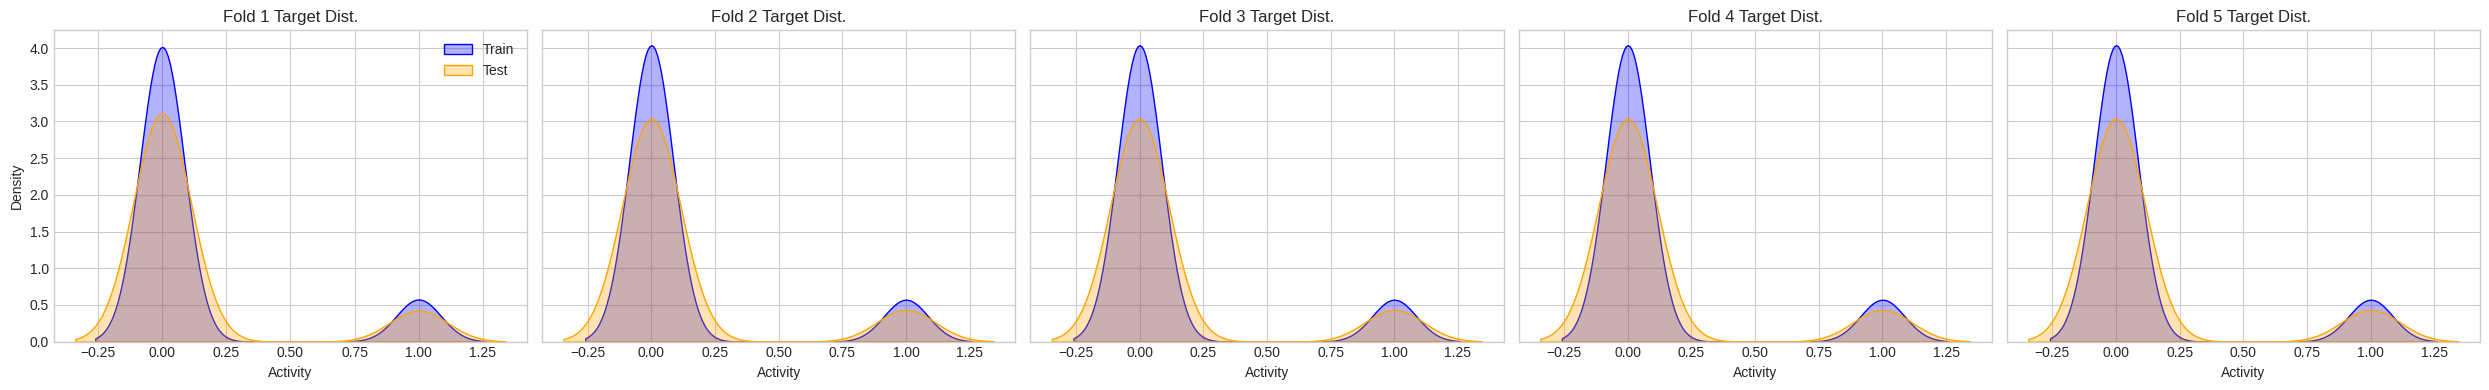

In [3]:
# Sınıflandırma olduğu için task_type='classification' diyoruz.
# Bu, RepeatedStratifiedKFold kullanmasını sağlar.
splitter = DataSplitter(df, target_col='Activity', split_type='random', task_type='classification')

print(f"Seçilen Strateji: {splitter.config['method_name']}")
print(f"Açıklama: {splitter.config.get('description', 'Custom Split')}")

# Diyagnostik: Foldlar arasındaki sınıf dağılımı dengeli mi?
plot_target_distribution(df, 'Activity', splitter)
plt.show()

In [4]:
# Modeller
models = {
    'LogisticReg': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42),
    'GBM': GradientBoostingClassifier(n_estimators=50, random_state=42)
}


results_dict = {name: [] for name in models.keys()}

print("5x5 Repeated CV Başlıyor...")

for i, (train_idx, test_idx) in enumerate(splitter.split()):
    # Veri hazırlığı
    X_train = df.iloc[train_idx].drop(columns=['Activity', 'SMILES'])
    y_train = df.iloc[train_idx]['Activity']
    X_test = df.iloc[test_idx].drop(columns=['Activity', 'SMILES'])
    y_test = df.iloc[test_idx]['Activity']
    
    for name, model in models.items():

        model.fit(X_train, y_train)
        

        y_proba = model.predict_proba(X_test)[:, 1]

        results_dict[name].append({
            'fold': i,
            'y_true': y_test.values,
            'y_proba': y_proba
        })


5x5 Repeated CV Başlıyor...
Using repeated_cv with 5 splits and 5 repeats.


In [5]:
metrics_data = []

for model_name, folds_data in results_dict.items():
    for fold_res in folds_data:
        # Metrik Hesapla
        metrics = MetricCalculator.get_classification_metrics(
            fold_res['y_true'], 
            fold_res['y_proba']
        )
        
        # Model ve Fold bilgisini ekle
        metrics['model'] = model_name
        metrics['fold'] = fold_res['fold']
        
        metrics_data.append(metrics)

# İstatistiksel Analiz İçin DataFrame Hazır
results_df = pd.DataFrame(metrics_data)

# Kontrol
print(results_df.head())

        MCC     Kappa   ROC_AUC    PR_AUC  Precision    Recall  \
0  0.275050  0.274274  0.709991  0.383875   0.380952  0.333333   
1  0.190764  0.169231  0.603200  0.275256   0.400000  0.160000   
2  0.253676  0.253012  0.761829  0.324485   0.363636  0.320000   
3  0.179374  0.172414  0.767771  0.386445   0.333333  0.200000   
4  0.174078  0.157895  0.696686  0.339595   0.363636  0.160000   

   Enrichment_Factor  Enrichment_at_1%  Enrichment_at_5%  Recall@90Prec  \
0           3.174603          8.333333               5.0       0.083333   
1           3.200000          4.000000               3.2       0.040000   
2           2.909091          4.000000               3.2       0.000000   
3           2.666667          8.000000               3.2       0.080000   
4           2.909091          8.000000               3.2       0.120000   

   TNR@90Recall        model  fold  
0      0.170455  LogisticReg     0  
1      0.080000  LogisticReg     1  
2      0.451429  LogisticReg     2  
3   

In [6]:
results_df.columns



Index(['MCC', 'Kappa', 'ROC_AUC', 'PR_AUC', 'Precision', 'Recall',
       'Enrichment_Factor', 'Enrichment_at_1%', 'Enrichment_at_5%',
       'Recall@90Prec', 'TNR@90Recall', 'model', 'fold'],
      dtype='object')


Validating Metric: MCC
Assumptions met (or forced). Running Parametric Tests (Repeated Measures ANOVA).

Validating Metric: ROC_AUC
Assumptions met (or forced). Running Parametric Tests (Repeated Measures ANOVA).

Validating Metric: Recall
Assumptions met (or forced). Running Parametric Tests (Repeated Measures ANOVA).

Validating Metric: Precision
Assumptions met (or forced). Running Parametric Tests (Repeated Measures ANOVA).
Metric: MCC | P-Value: 3.5979e-14 (parametric)
DEBUG: Using p-value column 'p-tukey' for significance testing.
DEBUG: Best Model identified as 'LogisticReg' based on MCC


/nfs/home/myuecel3/stats_for_mols/.venv/lib64/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/nfs/home/myuecel3/stats_for_mols/.venv/lib64/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/nfs/home/myuecel3/stats_for_mols/.venv/lib64/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


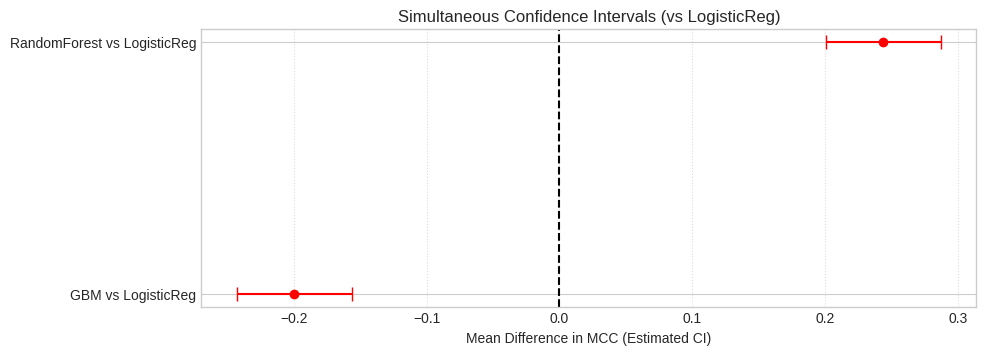

Metric: ROC_AUC | P-Value: 2.2155e-14 (parametric)
DEBUG: Using p-value column 'p-tukey' for significance testing.
DEBUG: Best Model identified as 'LogisticReg' based on ROC_AUC


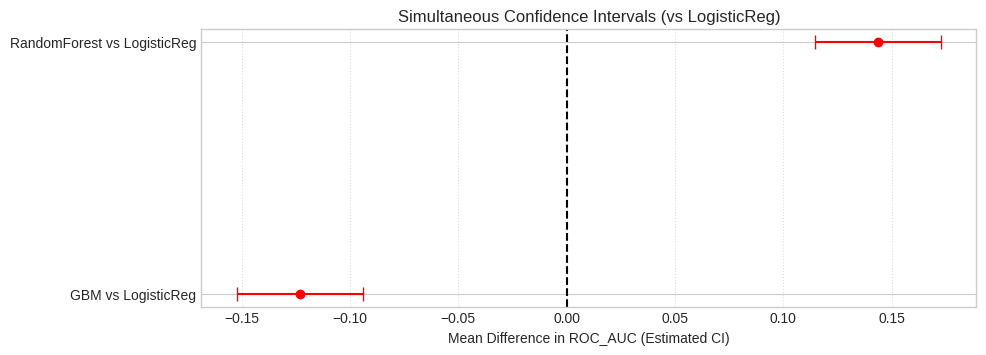

Metric: Recall | P-Value: 1.0155e-22 (parametric)
DEBUG: Using p-value column 'p-tukey' for significance testing.
DEBUG: Best Model identified as 'LogisticReg' based on Recall


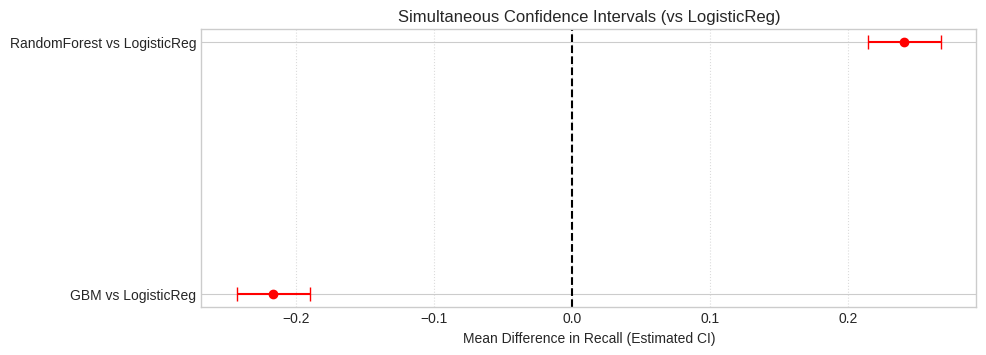

Metric: Precision | P-Value: 6.1795e-08 (parametric)
DEBUG: Using p-value column 'p-tukey' for significance testing.
DEBUG: Best Model identified as 'LogisticReg' based on Precision


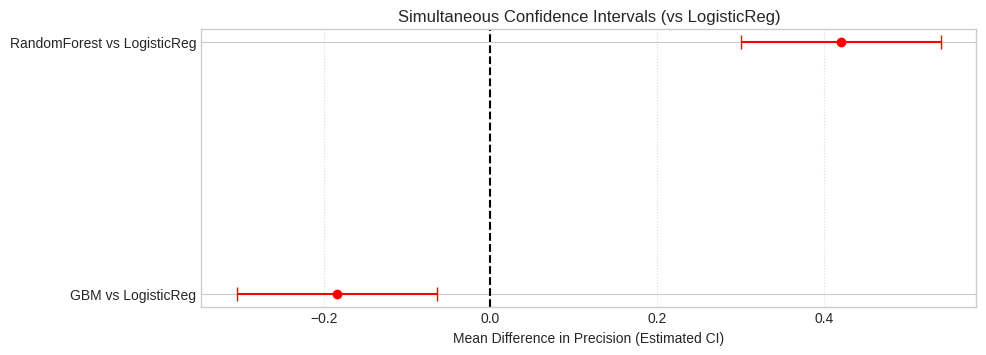

In [7]:
# MCC metriğine göre modelleri kıyaslayalım
metrics = ['MCC','ROC_AUC','Recall','Precision']
validator = StatisticalValidator(results_df, model_col='model', metric_col=metrics, subject_col='fold')
stats_report = validator.validate()


for metric in metrics:
    if metric in stats_report:
        report = stats_report[metric]
        p_val = report['global_pvalue']
        
        print(f"Metric: {metric} | P-Value: {p_val:.4e} ({report['method_used']})")
        
        if p_val < 0.05:
            # Yüksek mi iyi düşük mü? (Basit bir liste kontrolü)
            is_higher_better = metric in ['ROC_AUC', 'MCC', 'Precision', 'Recall', 'F1_Score']
            
            plot_simultaneous_ci(report['pairwise_results'], metric_name=metric, higher_is_better=is_higher_better)
            plt.show()

DEBUG: Using p-value column 'p-tukey' for significance testing.


/nfs/home/myuecel3/stats_for_mols/stats_for_mols/visualization/plots.py:176: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_matrix = p_matrix.applymap(get_star)


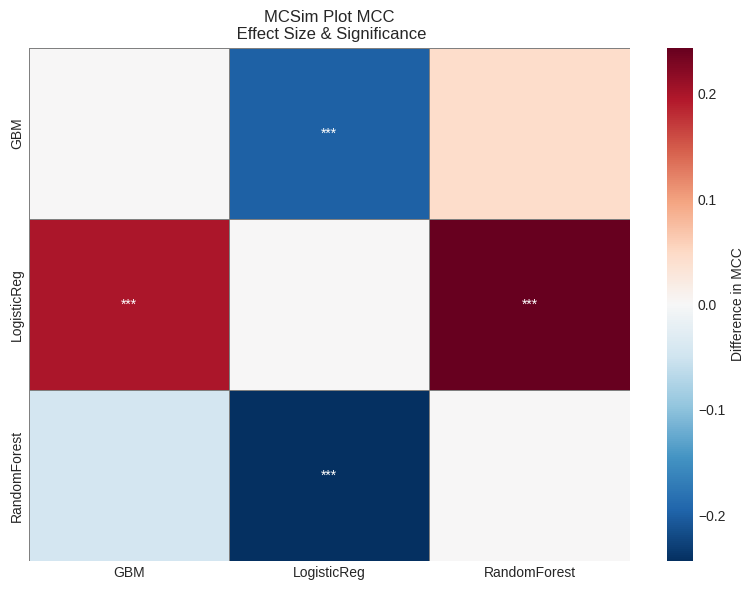

In [8]:
pairwise_df = stats_report['MCC']['pairwise_results']

if pairwise_df is not None:
    plot_mcsim(pairwise_df, metric_name='MCC')
    plt.show()

In [9]:
stats_report


{'MCC': {'assumptions': {'normality': np.False_,
   'normality_p_min': np.float64(0.0008200812841775521),
   'normality_warning': 'Normality assumption technically violated (p=0.0008). However, ANOVA is robust for N=25 (CLT), so proceeding with parametric test is recommended.',
   'sphericity': False,
   'sphericity_p': np.float64(0.002496142046532644),
   'valid_parametric': True},
  'method_used': 'parametric',
  'global_test': 'Repeated Measures ANOVA',
  'global_pvalue': np.float64(3.5979393150465616e-14),
  'pairwise_results':              A             B   mean(A)   mean(B)      diff        se  \
  0          GBM   LogisticReg  0.044220  0.243822 -0.199602  0.022141   
  1          GBM  RandomForest  0.044220  0.000000  0.044220  0.022141   
  2  LogisticReg  RandomForest  0.243822  0.000000  0.243822  0.022141   
  
             T       p-tukey    hedges  
  0  -9.015229  5.802026e-13 -2.049277  
  1   1.997254  1.201973e-01  0.594797  
  2  11.012483  0.000000e+00  3.874689  },

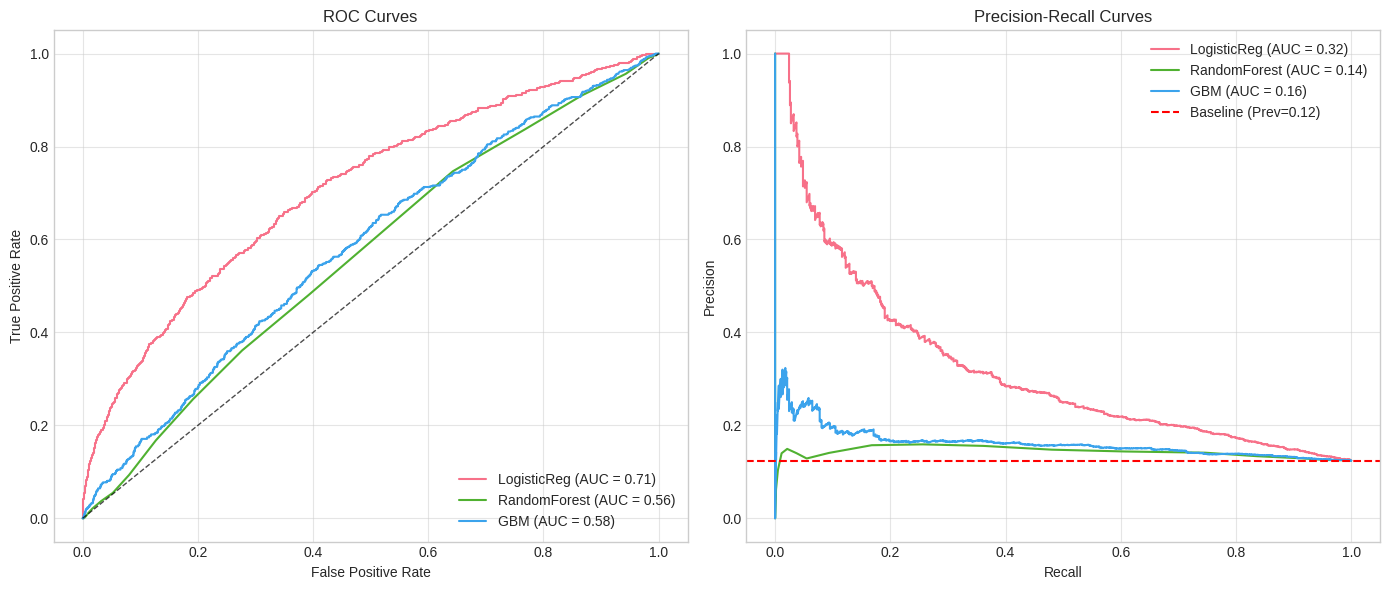

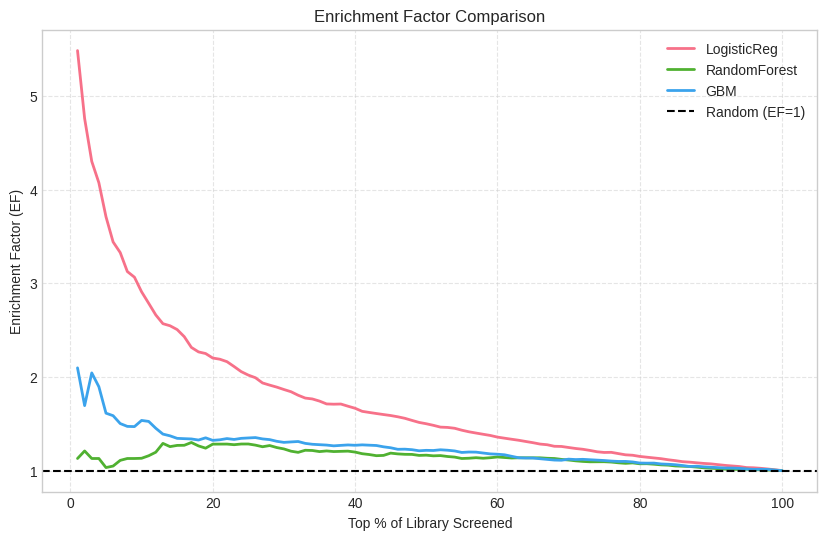

In [10]:

viz_data = {}

for name, folds_data in results_dict.items():
    y_true_all = np.concatenate([f['y_true'] for f in folds_data])
    y_proba_all = np.concatenate([f['y_proba'] for f in folds_data])
    
    viz_data[name] = {
        'y_true': y_true_all,
        'y_proba': y_proba_all
    }

MetricVisualizer.plot_roc_pr_curves(viz_data)
plt.show()

MetricVisualizer.plot_enrichment_curve(viz_data)
plt.show()

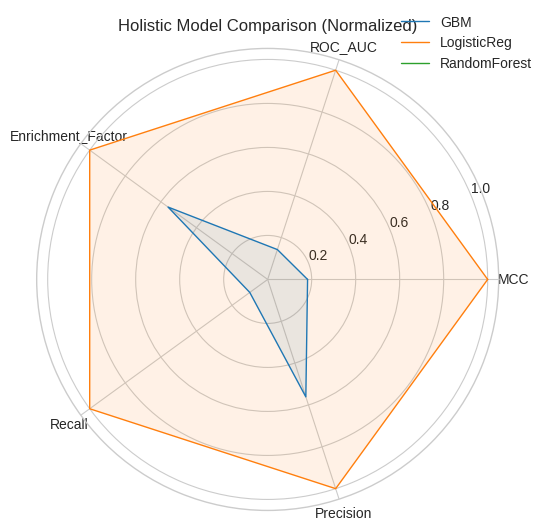

In [11]:
# Her model için metriklerin ortalamasını al
summary_df = results_df.groupby('model').mean()

# Radar Chart çiz
MetricVisualizer.plot_radar_summary(
    summary_df, 
    metrics_to_plot=['MCC', 'ROC_AUC', 'Enrichment_Factor', 'Recall', 'Precision']
)
plt.show()